In [1]:
import os
import math
import pickle
from scipy.ndimage.measurements import label
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import glob
from skimage.feature import hog
from car_finder import CarFinder
from lane_finder import LaneFinder
import itertools
from matplotlib import gridspec
%matplotlib inline

In [2]:
# define feature extraction function for experiment

def get_features(img,size=64,hist_bins=128, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1):
        img_resize = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
#         img_resize = (np.sqrt(img_resize.astype(np.float32)/255)*255).astype(np.uint8)
        img_LUV = cv2.cvtColor(img_resize, cv2.COLOR_RGB2LUV)
        img_feature = cv2.resize(img_LUV, (small_size, small_size), interpolation=cv2.INTER_LINEAR)
        hist_l = np.histogram(img_LUV[:, :, 0], bins=hist_bins, range=hist_range)
        width = 0.7 * (hist_l[1][1] - hist_l[1][0])
        center = (hist_l[1][:-1] + hist_l[1][1:]) / 2
        hist_u = np.histogram(img_LUV[:, :, 1], bins=hist_bins, range=hist_range)
        hist_v = np.histogram(img_LUV[:, :, 2], bins=hist_bins, range=hist_range)
        features_l, hog_image_l = hog(img_LUV[:, :, 0], orientations, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block,  cell_per_block), transform_sqrt=False,
                       feature_vector=False,visualise=True)
        features_u, hog_image_u = hog(img_LUV[:, :, 1], orientations, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block,  cell_per_block), transform_sqrt=False,
                       feature_vector=False,visualise=True)
        features_v, hog_image_v = hog(img_LUV[:, :, 2], orientations, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block,  cell_per_block), transform_sqrt=False,
                       feature_vector=False,visualise=True)
#         return np.hstack((img_feature.ravel(), hist_l[0], hist_u[0], hist_v[0], features_l, features_u, features_v))
        return img_resize,img_LUV,img_feature,hist_l,hist_u,hist_v,hog_image_l,hog_image_u,hog_image_v

In [3]:
# load test images

def image_load(files = "patches/vehicle/*.png"):
    images = []
    for file in glob.glob(files):
        img = mpimg.imread(file)
        images.append(img)
    return images

vehicles = image_load(files = "patches/vehicle/*.png")
non_vehicles = image_load(files = "patches/non_vehicle/*.png")

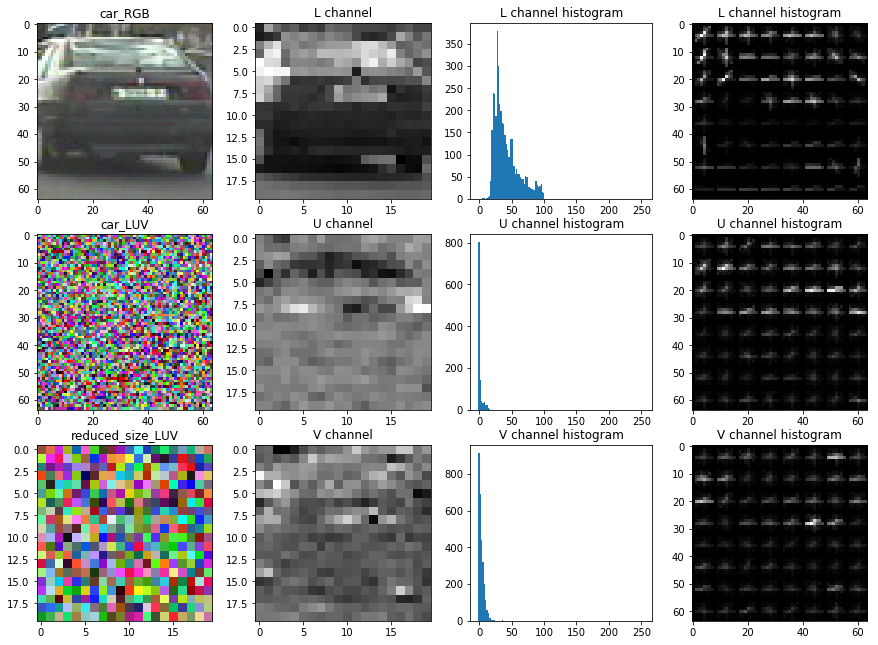

In [217]:
# features visualization

def feature_visualize():
    fig = plt.figure(figsize=(15,11))
    gs = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)
    ax00 = plt.subplot(gs[0,0])
    ax00.imshow(img_resize)
    ax00.set_title('car_RGB')
    ax10 = plt.subplot(gs[1,0])
    ax10.imshow(img_LUV)
    ax10.set_title('car_LUV')
    ax20 = plt.subplot(gs[2,0])
    ax20.imshow(img_feature)
    ax20.set_title('reduced_size_LUV')
    
    ax01 = plt.subplot(gs[0,1])
    ax01.imshow(img_feature[:,:,0],'gray')
    ax01.set_title('L channel')
    ax11 = plt.subplot(gs[1,1])
    ax11.imshow(img_feature[:,:,1],'gray')
    ax11.set_title('U channel')
    ax21 = plt.subplot(gs[2,1])
    ax21.imshow(img_feature[:,:,2],'gray')
    ax21.set_title('V channel')
    
    ax02 = plt.subplot(gs[0,2])
    ax02.bar(hist_l[1][:-1],hist_l[0],2)
    ax02.set_title('L channel histogram')
    ax12 = plt.subplot(gs[1,2])
    ax12.bar(hist_u[1][:-1],hist_u[0],2)
    ax12.set_title('U channel histogram')
    ax22 = plt.subplot(gs[2,2])
    ax22.bar(hist_v[1][:-1],hist_v[0],2)
    ax22.set_title('V channel histogram')
    
    ax03 = plt.subplot(gs[0,3])
    ax03.imshow(hog_image_l,'gray')
    ax03.set_title('L channel histogram')
    ax13 = plt.subplot(gs[1,3])
    ax13.imshow(hog_image_u,'gray')
    ax13.set_title('U channel histogram')
    ax23 = plt.subplot(gs[2,3])
    ax23.imshow(hog_image_v,'gray')
    ax23.set_title('V channel histogram')
    
    fig.savefig('output_images/car_features_4.png', bbox_inches='tight')

img = vehicles[4]
img_resize,img_LUV,img_feature,hist_l,hist_u,hist_v,hog_image_l,hog_image_u,hog_image_v = get_features(img,size=64,hist_bins=128, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1)
feature_visualize()
    

In [223]:
# define feature extraction function

vehicle_dir = "train_images/vehicles"
non_vehicle_dir = "train_images/non-vehicles"
total_imgs = 0

spatial_size = (64, 64)
n_bins = 128
hist_range = (0, 255)

def create_features_from_dir(root_dir):
    print(car_finder.num_features)
    all_features = []
    for subdir in (os.listdir(root_dir)):
        if os.path.isdir(os.path.join(root_dir,subdir)):
            for file in glob.glob(os.path.join(root_dir,subdir)+'/*.png'):
                img = mpimg.imread(file)
                img = (img.astype(np.float32)/np.max(img)*255).astype(np.uint8)
                features = car_finder.get_features(img)
                all_features.append(features)
    return np.vstack(all_features)

In [224]:
# define classifier training function

def start_train():
    print("Featuring started")
    X_cars = create_features_from_dir(vehicle_dir)
    y_cars = np.ones(X_cars.shape[0], dtype=np.uint8)
    X_non_cars = create_features_from_dir(non_vehicle_dir)
    y_non_cars = np.zeros(X_non_cars.shape[0], dtype=np.uint8)
    print("Featuring ended")
    X = np.vstack((X_cars, X_non_cars))
    y = np.concatenate((y_cars, y_non_cars))

    scaler = StandardScaler().fit(X)
    scaled_X = scaler.transform(X)

    del X_cars
    del X_non_cars
    print(scaled_X.shape)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.10, random_state=40)
    cls = LinearSVC(C=1e-4, dual=False, max_iter=5)
    cls.fit(X_train, y_train)
    result = cls.predict(X_test)
    
    return scaler,cls,result,X_test,y_test

In [225]:
# define classifier evaluation function

def performance_cls():
    true = y_test == result
    test_len = len(y_test)
    positive = result == 1
    true_positive = np.sum(true & positive)
    true_negative = np.sum(true & np.logical_not(positive))
    false_negative = np.sum(np.logical_not(true) & np.logical_not(positive))
    false_positive = np.sum(np.logical_not(true) & positive)
    print("TP {0}, TN {1}, FN {2}, FP {3}".format(float(true_positive)/np.sum(positive), float(true_negative)/(test_len-np.sum(positive)),
                                                float(false_negative)/(test_len-np.sum(positive)), float(false_positive)/np.sum(positive)))
    score = cls.score(X_test, y_test)
    print(score)
    true_positive_ratio = float(true_positive)/np.sum(positive)
    true_negative_ratio = float(true_negative)/(test_len-np.sum(positive))
    false_negative_ratio = float(false_negative)/(test_len-np.sum(positive))
    false_positive_ratio = float(false_positive)/np.sum(positive)
    
    return true_positive,true_negative,false_negative,false_positive,test_len,true_positive_ratio,true_negative_ratio,false_negative_ratio,false_positive_ratio,score

In [226]:
# train and evaluate the classifier

car_finder = CarFinder(64, hist_bins=64, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1)
scaler,cls,result,X_test,y_test = start_train()
true_positive,true_negative,false_negative,false_positive,test_len,true_positive_ratio,true_negative_ratio,false_negative_ratio,false_positive_ratio,score=performance_cls()

Featuring started
3696
3696
Featuring ended
(17760, 3696)
TP 0.9988235294117647, TN 0.9956803455723542, FN 0.004319654427645789, FP 0.001176470588235294
0.997184684685


In [227]:
# save trained classifier

data = {
        'scaler': scaler,
        'classifier': cls
        }

with open('classifier.p', 'wb') as f:
    pickle.dump(data, f)

In [69]:
# model hyper-parameters grid search experiment

hist_bins=[64,128,256]
small_size=[10,20]
orientations=[6,9,12]
pix_per_cell=[8,12]
cell_per_block=[1,2]

index_structure = [hist_bins, small_size, orientations, pix_per_cell, cell_per_block]
index_list = list(itertools.product(*index_structure))

history = []

for index in index_list:
    car_finder = CarFinder(64, hist_bins=index[0], small_size=index[1], orientations=index[2], pix_per_cell=index[3], cell_per_block=index[4])
    total_features = car_finder.num_features
    scaler,cls,result,X_test,y_test = start_train()
    true_positive,true_negative,false_negative,false_positive,test_len,true_positive_ratio,true_negative_ratio,false_negative_ratio,false_positive_ratio,score=performance_cls()
    history.append(np.array([index[0],index[1],index[2],index[3],index[4],total_features,
             true_positive,true_negative,false_negative,false_positive,test_len,true_positive_ratio,true_negative_ratio,false_negative_ratio,false_positive_ratio,score]))

history = np.asarray(history)
# np.savetxt('model_history.csv', history, delimiter = ',')

Featuring started
1644
1644
Featuring ended
(17760, 1644)
TP 0.9929577464788732, TN 0.9924242424242424, FN 0.007575757575757576, FP 0.007042253521126761
0.99268018018
Featuring started
4020
4020
Featuring ended
(17760, 4020)
TP 0.9964747356051704, TN 0.9945945945945946, FN 0.005405405405405406, FP 0.0035252643948296123
0.995495495495
Featuring started
942
942
Featuring ended
(17760, 942)
TP 0.9917452830188679, TN 0.9870689655172413, FN 0.01293103448275862, FP 0.008254716981132075
0.989301801802
Featuring started
1644
1644
Featuring ended
(17760, 1644)
TP 0.9917840375586855, TN 0.9913419913419913, FN 0.008658008658008658, FP 0.008215962441314555
0.991554054054
Featuring started
2220
2220
Featuring ended
(17760, 2220)
TP 0.9964705882352941, TN 0.9935205183585313, FN 0.0064794816414686825, FP 0.0035294117647058825
0.994932432432
Featuring started
5784
5784
Featuring ended
(17760, 5784)
TP 0.9964788732394366, TN 0.9956709956709957, FN 0.004329004329004329, FP 0.0035211267605633804
0.996058

In [4]:
# define boxes drawing function

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[2],bbox[1]), (bbox[0],bbox[3]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
# initial global vairables
    from settings import CALIB_FILE_NAME, PERSPECTIVE_FILE_NAME, UNWARPED_SIZE, ORIGINAL_SIZE
    with open('classifier.p', 'rb') as f:
        data = pickle.load(f)

    scaler = data['scaler']
    cls = data['classifier']

    test_images_dir = "test_images"
    output_images_dir = "output_images"
    window_size=[64, 80, 96, 112, 128, 160]#, 192, 224, 256]
    window_roi=[((200, 400),(1080, 550)), ((100, 400),(1180, 550)), ((0, 380),(1280, 550)),
                ((0, 360),(1280, 550)), ((0, 360),(1280, 600)), ((0, 360),(1280, 670)) ]#,

    with open(CALIB_FILE_NAME, 'rb') as f:
        calib_data = pickle.load(f)
        
    cam_matrix = calib_data["cam_matrix"]
    dist_coeffs = calib_data["dist_coeffs"]
    img_size = calib_data["img_size"]

    with open(PERSPECTIVE_FILE_NAME, 'rb') as f:
        perspective_data = pickle.load(f)

    perspective_transform = perspective_data["perspective_transform"]
    pixels_per_meter = perspective_data['pixels_per_meter']
    orig_points = perspective_data["orig_points"]

In [6]:
# run car finder

cf = CarFinder(64, hist_bins=64, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1,
                       classifier=cls, scaler=scaler, window_sizes=window_size, window_rois=window_roi,
                       transform_matrix=perspective_transform, warped_size=UNWARPED_SIZE,
                       pix_per_meter=pixels_per_meter)

img = mpimg.imread('test_images/test6.jpg')
img = cv2.undistort(img, cam_matrix, dist_coeffs)
cf.find_cars(img, reset = False)

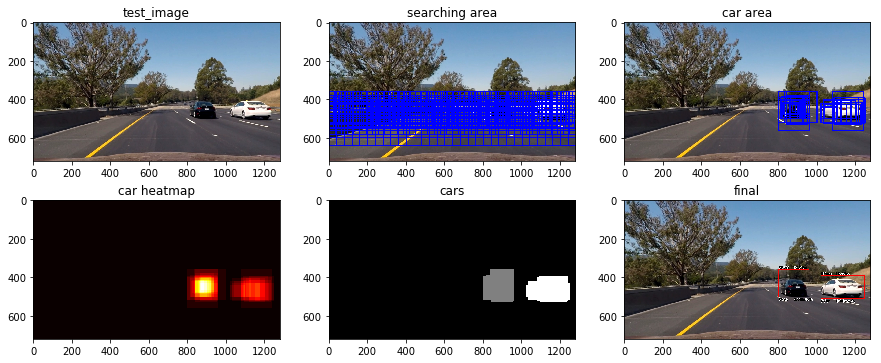

In [9]:
# visualize outputs from car finder step by step

search_area = draw_boxes(img,cf.all_windows,thick=3)
car_area = draw_boxes(img,cf.car_windows)

x = cf.car_windows[0]
imcopy = np.copy(img)

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

ax00 = plt.subplot(gs[0,0])
ax00.imshow(img)
ax00.set_title('test_image')

ax01 = plt.subplot(gs[0,1])
ax01.imshow(search_area)
ax01.set_title('searching area')

ax02 = plt.subplot(gs[0,2])
ax02.imshow(car_area)
ax02.set_title('car area')

ax10 = plt.subplot(gs[1,0])
ax10.imshow(cf.heatmap,'hot')
ax10.set_title('car heatmap')

ax11 = plt.subplot(gs[1,1])
ax11.imshow(cf.label_img,'gray')
ax11.set_title('cars')

ax12 = plt.subplot(gs[1,2])
ax12.imshow(cf.draw_cars(img))
ax12.set_title('final')

# fig.savefig('output_images/car_searching_6.png', bbox_inches='tight')